In [26]:
from trackml.dataset import load_event
from trackml.utils import add_position_quantities, add_momentum_quantities, decode_particle_id

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from tqdm import tqdm

path = '/nfs/fanae/user/uo290313/Desktop/TFG/dataset/trackml-particle-identification/train_1/'
event = 'event000001000'

print('Loading event {}'.format(path+event))

hits, cells, particles, truth = load_event(path+event)

mem_bytes = (hits.memory_usage(index=True).sum() 
             + cells.memory_usage(index=True).sum() 
             + particles.memory_usage(index=True).sum() 
             + truth.memory_usage(index=True).sum())
print('{} memory usage {:.2f} MB'.format(event, mem_bytes / 2**20))

Loading event /nfs/fanae/user/uo290313/Desktop/TFG/dataset/trackml-particle-identification/train_1/event000001000
event000001000 memory usage 18.46 MB


   hit_id          x         y       z  volume_id  layer_id  module_id
0       1 -64.409897 -7.163700 -1502.5          7         2          1
1       2 -55.336102  0.635342 -1502.5          7         2          1
2       3 -83.830498 -1.143010 -1502.5          7         2          1
3       4 -96.109100 -8.241030 -1502.5          7         2          1
4       5 -62.673599 -9.371200 -1502.5          7         2          1


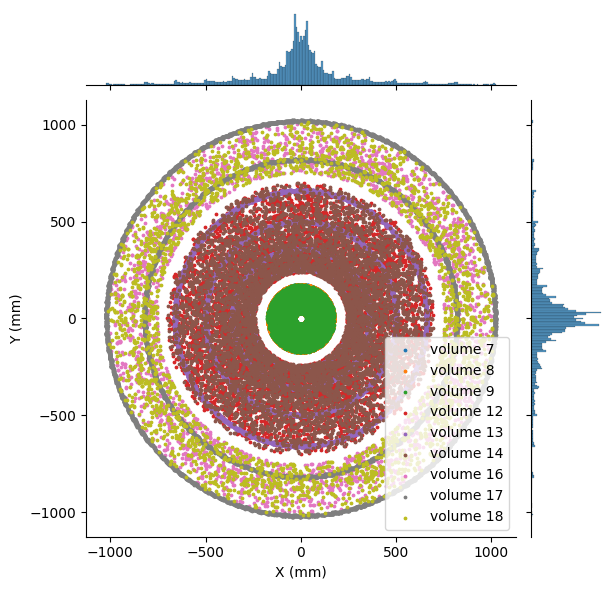

In [27]:
'''
Representación de los hits
'''
print(hits.head())

g = sns.jointplot(x=hits.x, y=hits.y, s=1, height=6)
g.ax_joint.cla()
plt.sca(g.ax_joint)

volumes = hits.volume_id.unique()
for volume in volumes:
    v = hits[hits.volume_id == volume]
    plt.scatter(v.x, v.y, s=3, label='volume {}'.format(volume))

plt.xlabel('X (mm)')
plt.ylabel('Y (mm)')
plt.legend()
plt.show()

Dimensión dataset hits:   (120939, 7)
=========== Hits centrales ===========
       hit_id          x          y           z  volume_id  layer_id  \
16873   16874 -32.554401  -3.648710 -469.864990          8         2   
16874   16875 -33.153702  -1.934740 -423.516998          8         2   
16875   16876 -26.362400 -18.423700 -461.375000          8         2   
16876   16877 -12.034100 -29.649799 -464.428009          8         2   
16877   16878 -15.127200 -28.159300 -439.713989          8         2   

       module_id  
16873          1  
16874          1  
16875          2  
16876          3  
16877          3  
(29172, 7)
Tomamos solo un 24.1213% de los hits
Tengo un total de 1085 módulos
Tengo un total de 4 capas
Mis capas son: [2 4 6 8]
Data.shape() = (29172, 3)
Numero de hits en la primera capa: 8892
Data.shape() = (8892, 3)
Data.shape() = (1000, 3)
Dimensión de smoothed_states: (1, 6, 1)
Dimensión de smoothed_states: (1, 6, 1)
Dimensión de smoothed_positions: (1, 3, 1)
Dimensi

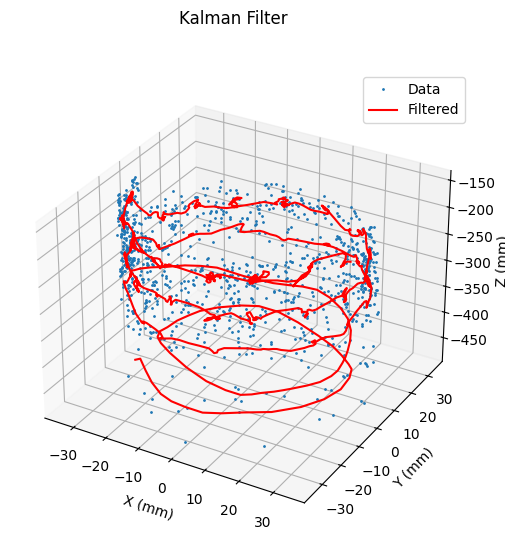

In [28]:
import importlib
import kalman_filter
importlib.reload(kalman_filter)
from kalman_filter import KalmanFilter
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

#print(hits.head())
print("Dimensión dataset hits:  ", hits.shape)
'''
Voy a querer elegir primero solo los hits centrales, es decir, los del volumen 8
'''

print("=========== Hits centrales ===========")
hits_centrales = hits[hits.volume_id == 8]
print(hits_centrales.head())
print(hits_centrales.shape)

print("Tomamos solo un {:.4f}% de los hits".format(hits_centrales.shape[0]/hits.shape[0]*100))

print(f"Tengo un total de {hits_centrales.module_id.nunique()} módulos")
print(f"Tengo un total de {hits_centrales.layer_id.nunique()} capas")
print(f"Mis capas son: {hits_centrales.layer_id.unique()}")

data = hits_centrales[['x', 'y', 'z']].values
#print(data)
print(f"Data.shape() = {data.shape}")

# Número de hits en la primera capa
print(f"Numero de hits en la primera capa: {hits_centrales[hits_centrales.layer_id == 2].shape[0]}")

# Tomemos solo los hits en la primera capa
data = hits_centrales[hits_centrales.layer_id == 2][['x', 'y', 'z']].values
print(f"Data.shape() = {data.shape}")

data = data[:1000]
print(f"Data.shape() = {data.shape}")

'''
plt.plot(data[:,0], 'o', label='X', markersize=.3)
plt.xlabel('Hit')
plt.ylabel('X (mm)')
plt.show()
'''
'''
Tengo que calcular x0 como trayectoria inicial entre un par de hits. 
'''

i = 1
hit_1 = hits_centrales[hits_centrales.module_id == i].iloc[0]
hit_2 = hits_centrales[hits_centrales.module_id == i+1].iloc[0]   

#hit_1 = hits_centrales.iloc[0]
#hit_2 = hits_centrales.iloc[1]

x1, y1, z1 = hit_1['x'], hit_1['y'], hit_1['z']
x2, y2, z2 = hit_2['x'], hit_2['y'], hit_2['z']

dt = 1.0

slope_x = (x2 - x1) / 1.0
slope_y = (y2 - y1) / 1.0
slope_z = (z2 - z1) / 1.0

#x0 = np.array([data[0,0], 0, data[0,1], 0, data[0,2], 0])
x0 = np.array([x1, slope_x, y1, slope_y, z1, slope_z]).reshape(-1, 1)
#print(x0)

dim_data = data.shape[1]

F = np.array([[1, dt, 0,  0,  0,  0],
              [0,  1,  0,  0,  0,  0],
              [0,  0,  1, dt,  0,  0],
              [0,  0,  0,  1,  0,  0],
              [0,  0,  0,  0,  1, dt],
              [0,  0,  0,  0,  0,  1]])

H = np.array([[1, 0, 0, 0, 0, 0],
              [0, 0, 1, 0, 0, 0],
              [0, 0, 0, 0, 1, 0]])

C = np.eye(6) * 1e-3
Q = np.eye(6) * 0.1
R = np.eye(3) * 0.3

kf = KalmanFilter(C = C, F = F, 
                  H = H, Q = Q, R = R, x0 = x0)

trajectory = []
for i in range(int(len(data))):
    m = data[i]
    kf.predict()
    kf.update(m)
    kf.smoothing_RTS()
    smoothed_states, smoothed_positions = kf.smoothing_RTS()
    #trajectory.append(smoothed_positions)
    #trajectory.append(kf.x[[0, 2, 4]].flatten())


# Convertir a DataFrame, las posiciones x, y, z
smoothed_df = pd.DataFrame(smoothed_positions[:, :, 0], columns=["x", "y", "z"])

#with open('smoothed_df.txt', 'w') as f:
#    f.write(smoothed_df.to_string())

trajectory = smoothed_states
print(f"trajectory.shape = {trajectory.shape}")

print("\n=========== Smoothed_df ===========")
print(smoothed_df.head())


fig = plt.figure(figsize=(6, 6))
fig.suptitle('Kalman Filter')

ax = fig.add_subplot(111, projection='3d')
ax.plot(data[:,0], data[:,1], data[:,2], 'o', label='Data', markersize=1)
ax.plot(trajectory[:,0], trajectory[:,2], trajectory[:,4], label='Filtered', color='red')
ax.set_xlabel('X (mm)')
ax.set_ylabel('Y (mm)')
ax.set_zlabel('Z (mm)')
plt.legend()
plt.show()

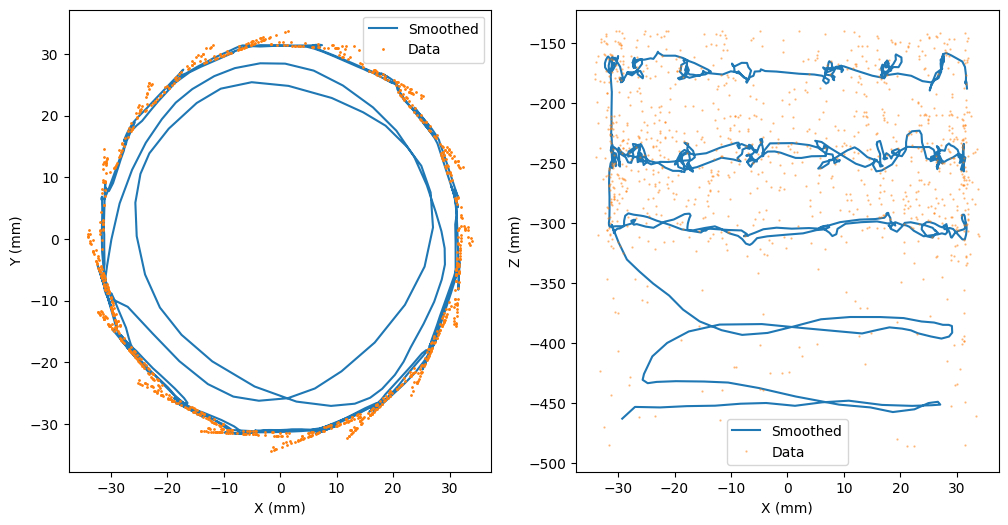

In [29]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(smoothed_df['x'], smoothed_df['y'], '-', label='Smoothed', markersize=.6)
plt.plot(data[:,0], data[:,1], 'o', label='Data', markersize=1)
plt.xlabel('X (mm)')
plt.ylabel('Y (mm)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(smoothed_df['x'], smoothed_df['z'], '-', label='Smoothed', markersize=.6)
plt.plot(data[:,0], data[:,2], 'o', label='Data', markersize=.6, alpha=0.5)
plt.xlabel('X (mm)')
plt.ylabel('Z (mm)')
plt.legend()

plt.show()

1. Seleccionar pares de hits prometedores. 50 pares de hits entre capas adyacentes.

        particle_id        vx        vy        vz         px         py  \
0  4503668346847232 -0.009288  0.009861 -0.077879  -0.055269   0.323272   
1  4503737066323968 -0.009288  0.009861 -0.077879  -0.948125   0.470892   
2  4503805785800704 -0.009288  0.009861 -0.077879  -0.886484   0.105749   
3  4503874505277440 -0.009288  0.009861 -0.077879   0.257539  -0.676718   
4  4503943224754176 -0.009288  0.009861 -0.077879  16.439400 -15.548900   

          pz  q  nhits         r      phi     theta  
0  -0.203492 -1      8  0.079048  2.32629  2.969372  
1   2.010060  1     11  0.079048  2.32629  2.969372  
2   0.683881 -1      0  0.079048  2.32629  2.969372  
3   0.991616  1     12  0.079048  2.32629  2.969372  
4 -39.824902  1      3  0.079048  2.32629  2.969372  


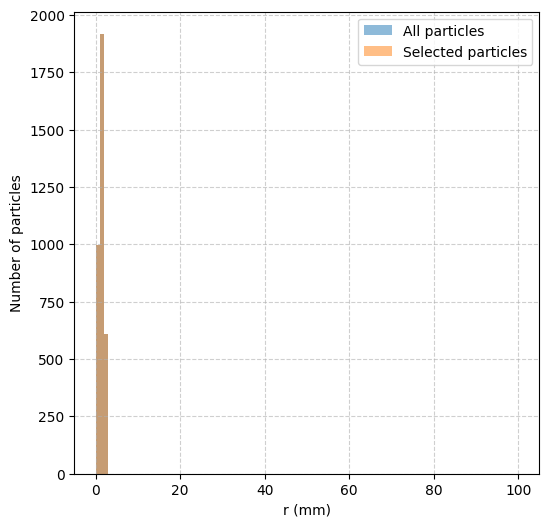

    hit_id          x         y       z  volume_id  layer_id  module_id
1        2 -55.336102  0.635342 -1502.5          7         2          1
9       10 -90.292900 -3.269370 -1502.5          7         2          1
10      11 -59.182999 -0.670508 -1502.5          7         2          1
12      13 -72.533997  2.642190 -1502.5          7         2          1
14      15 -63.436501 -3.262220 -1502.5          7         2          1
Los datos que tomo son un 100.0000% de los datos originales


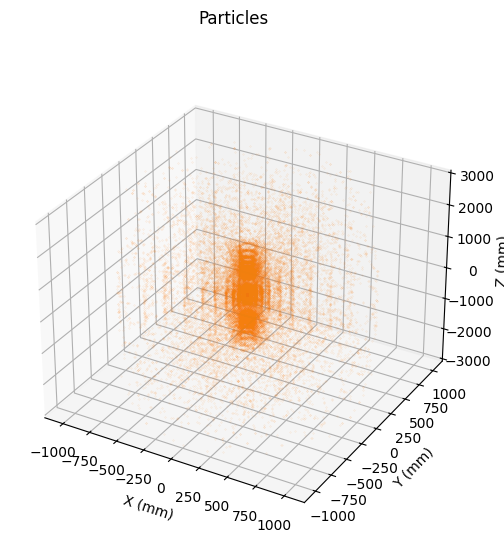

In [32]:
def distance(particle):
    ''' Distancia en mm de la partícula al origen'''
    return np.sqrt(particle.vx**2 + particle.vy**2 + particle.vz**2)

particles['r'] = distance(particles)
particles['phi'] = np.arctan2(particles.vy, particles.vx)
particles['theta'] = np.arccos(particles.vz / particles.r)

print(particles.head())

# Voy a coger solo las partículas con r < 2.6
particles_all = particles
particles = particles[particles.r < 2.6]

# Con ese radio, voy a coger solo las partículas con z entre -25 y 25 mm
particles = particles[(particles.vz > -25) & (particles.vz < 25)]

# Histograma normalizado a 1 de la variable r
plt.figure(figsize=(6, 6))
plt.hist(particles_all.r, bins=100, range=(0, 100), density=False, alpha=0.5, label='All particles')
plt.hist(particles.r, bins=100, range=(0, 100), density=False, alpha=0.5, label='Selected particles')
plt.legend()
plt.xlabel('r (mm)')    
plt.ylabel('Number of particles')
plt.grid(linestyle='--', alpha=0.6)
plt.show()

# Del truth cojo solo las partículas que están en particles
truth = truth[truth.particle_id.isin(particles.particle_id)]

# Cojo ahora los hits_id que están en truth
hits_all = hits
hits = hits[hits.hit_id.isin(truth.hit_id)]
print(hits.head())

print("Los datos que tomo son un {:.4f}% de los datos originales".format(hits.shape[0]/hits_all.shape[0]*100))


# Represento el dataset de particles en 3D
fig = plt.figure(figsize=(6, 6))
plt.suptitle('Particles')
ax = fig.add_subplot(111, projection='3d')
ax.plot(particles.vx, particles.vy, particles.vz, 'o', markersize=1)
ax.plot(hits.x, hits.y, hits.z, 'o', markersize=.2, alpha=0.25)
ax.set_xlabel('X (mm)')
ax.set_ylabel('Y (mm)')
ax.set_zlabel('Z (mm)')
plt.show()

# Ahora busco los hits correspondientes a estas partículas
particles_ids = particles.particle_id.values    # Obtengo los valores de la columna particle_id
#print(particles_ids)

#hits = hits[hits.hit_id.isin(particles_ids)]
#print(hits.head())


#print(particles.head())
#print(particles.shape)

/tmp/ipykernel_24696/1255827246.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hits_centrales['r'] = np.sqrt(hits_centrales.x**2 + hits_centrales.y**2 + hits_centrales.z**2)


hits_1.shape = (0, 8)
hits_2.shape = (579, 8)


Calculando distancias con vertex constraint: 0it [00:00, ?it/s]

Empty DataFrame
Columns: [hit_1, hit_2, distance]
Index: []


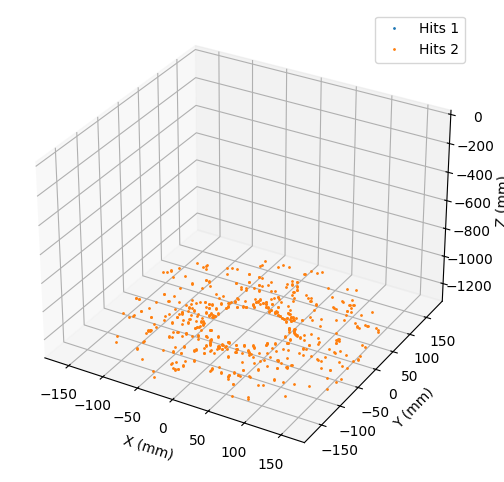

"\n# Gráfico de distancias\nfig = plt.figure(figsize=(6, 6))\nplt.plot(distances['distance'], 'o', markersize=1)\nplt.xlabel('Pair')\nplt.ylabel('Distance (mm)')\nplt.show()\n"

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

def distance(hit1, hit2):
    ''' Distancia entre dos hits '''
    dist = np.linalg.norm(hit1 - hit2)
    vector = hit2 - hit1
    return dist, vector

def cos_angle(v1, v2):
    ''' Calcula el coseno del ángulo entre dos vectores '''
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))


# Tomamos solo los hits centrales del volumen 7
hits_centrales = hits[hits.volume_id == 7]

# Defino la posición del vértice
vertex = np.array([0, 0, 0])
cos_threshold = 0.8  # Umbral de alineamiento

hits_max = 1000  # Número de iteraciones máximas

hits_centrales['r'] = np.sqrt(hits_centrales.x**2 + hits_centrales.y**2 + hits_centrales.z**2)

# Los hits de la capa más cercana al vértice 
hits_1 = hits_centrales[hits_centrales.layer_id == 2][:hits_max].reset_index(drop=True)
# Voy a considerar los hits cercanos al vértice
hits_1 = hits_1[hits_1.r < 40].reset_index(drop=True)

# Defino los hits de la siguiente capa
hits_2 = hits_centrales[hits_centrales.layer_id == 4][:hits_max].reset_index(drop=True)

print(f"hits_1.shape = {hits_1.shape}")
print(f"hits_2.shape = {hits_2.shape}")

# Crear un DataFrame con las distancias entre hits con vertex constraint
distances = []
vectors = []

for i in tqdm(range(len(hits_1)), desc="Calculando distancias con vertex constraint"):
    hit1_pos = hits_1.iloc[i][['x', 'y', 'z']].values
    v1 = hit1_pos - vertex  # Vector desde el vértice al primer hit
    
    for j in range(len(hits_2)):
        hit2_pos = hits_2.iloc[j][['x', 'y', 'z']].values
        v2 = hit2_pos - hit1_pos  # Vector desde el primer hit al segundo

        # Aplicamos la condición de alineamiento con el vértice
        if cos_angle(v1, v2) >= cos_threshold:
            dist, vector = distance(hit1_pos, hit2_pos)
            distances.append([i, j, dist])
            vectors.append(vector)

distances = pd.DataFrame(distances, columns=['hit_1', 'hit_2', 'distance'])
print(distances.head())

hits_1_np = hits_1[['x', 'y', 'z']].values
hits_2_np = hits_2[['x', 'y', 'z']].values

# Gráfico en 3D
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot(hits_1_np[:,0], hits_1_np[:,1], hits_1_np[:,2], 'o', label='Hits 1', markersize=1)
ax.plot(hits_2_np[:,0], hits_2_np[:,1], hits_2_np[:,2], 'o', label='Hits 2', markersize=1)

# Graficar solo los vectores que cumplen la restricción
for idx in range(int(len(vectors))):
    origin_idx = distances.iloc[idx]['hit_1']
    origin = hits_1_np[int(origin_idx)]
    vector = vectors[idx]
    ax.quiver(origin[0], origin[1], origin[2],
              vector[0], vector[1], vector[2],
              color='red', linewidth=0.5)

ax.set_xlabel('X (mm)')
ax.set_ylabel('Y (mm)')
ax.set_zlabel('Z (mm)')
plt.legend()
plt.show()

'''
# Gráfico de distancias
fig = plt.figure(figsize=(6, 6))
plt.plot(distances['distance'], 'o', markersize=1)
plt.xlabel('Pair')
plt.ylabel('Distance (mm)')
plt.show()
'''